# Introduction

In this notebook, we set out to determine if there was a correlation between conformational change and the length of CDR loops.
We looked at both the correlation of bulk movements when loops where aligned on the framework regions and also the deformation effects when loops are aligned to one another.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

# Loading data

In [2]:
results_fw_align = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/rmsd_cdr_fw_align_results.csv')
results_fw_align['alignment'] = 'framework'

In [3]:
results_loop_align = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/rmsd_cdr_loop_align_results.csv')
results_loop_align['alignment'] = 'loop'

In [4]:
results = pd.concat([results_fw_align, results_loop_align])
results

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,rmsd,alignment
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,1.932806,framework
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,2,1.308598,framework
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,3,1.244062,framework
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,1,0.809066,framework
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,2,0.688597,framework
...,...,...,...,...,...,...,...
1581,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,2,0.206414,loop
1582,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,3,0.459090,loop
1583,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,1,0.255668,loop
1584,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,2,0.175123,loop


## Loading meta data

In [5]:
apo_holo_summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')

apo_holo_summary_df['id'] = apo_holo_summary_df['file_name'].str.replace('.pdb$', '', regex=True)

apo_holo_summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug,id
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01,1ao7_D-E-C-A-B_tcr_pmhc
1,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01,1bd2_D-E-C-A-B_tcr_pmhc
2,1bii_A-B-P_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1bii_A-B-P_pmhc
3,1ddh_A-B-P_pmhc.pdb,1ddh,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1ddh_A-B-P_pmhc
4,1duz_A-B-C_pmhc.pdb,1duz,pmhc,apo,NaN,NaN,C,A,B,NaN,LLFGYPVYV,hla_a_02_01,1duz_A-B-C_pmhc
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,8gon_D-E-C-A-B_tcr_pmhc.pdb,8gon,tcr_pmhc,holo,D,E,C,A,B,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN,8gon_D-E-C-A-B_tcr_pmhc
354,8gop_A-B_tcr.pdb,8gop,tcr,apo,A,B,NaN,NaN,NaN,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN,8gop_A-B_tcr
355,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02,8gvb_A-B-P-H-L_tcr_pmhc
356,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02,8gvg_A-B-P-H-L_tcr_pmhc


In [6]:
cdr_types = ['CDR-A1', 'CDR-A2', 'CDR-A3','CDR-B1', 'CDR-B2', 'CDR-B3']
apo_holo_summary_df[cdr_types] = apo_holo_summary_df['cdr_sequences_collated'].str.split('-').apply(pd.Series)

In [7]:
apo_holo_summary_df = apo_holo_summary_df.melt(
    id_vars=[col for col in apo_holo_summary_df.columns if col not in cdr_types],
    var_name='cdr_type',
    value_name='cdr_sequence',
    value_vars=cdr_types,
)

In [8]:
apo_holo_summary_df[['chain_type', 'cdr']] = apo_holo_summary_df['cdr_type'].map(
    lambda cdr_type: ('alpha_chain' if cdr_type[-2] == 'A' else 'beta_chain',
                      int(cdr_type[-1]))
).apply(pd.Series)

In [9]:
apo_holo_summary_df['cdr_length'] = apo_holo_summary_df['cdr_sequence'].str.len()

In [10]:
apo_holo_summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug,id,cdr_type,cdr_sequence,chain_type,cdr,cdr_length
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01,1ao7_D-E-C-A-B_tcr_pmhc,CDR-A1,DRGSQS,alpha_chain,1,6.0
1,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01,1bd2_D-E-C-A-B_tcr_pmhc,CDR-A1,NSMFDY,alpha_chain,1,6.0
2,1bii_A-B-P_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1bii_A-B-P_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
3,1ddh_A-B-P_pmhc.pdb,1ddh,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1ddh_A-B-P_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
4,1duz_A-B-C_pmhc.pdb,1duz,pmhc,apo,NaN,NaN,C,A,B,NaN,LLFGYPVYV,hla_a_02_01,1duz_A-B-C_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,8gon_D-E-C-A-B_tcr_pmhc.pdb,8gon,tcr_pmhc,holo,D,E,C,A,B,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN,8gon_D-E-C-A-B_tcr_pmhc,CDR-B3,ASTWGRASTDTQY,beta_chain,3,13.0
2144,8gop_A-B_tcr.pdb,8gop,tcr,apo,A,B,NaN,NaN,NaN,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN,8gop_A-B_tcr,CDR-B3,ASTWGRASTDTQY,beta_chain,3,13.0
2145,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02,8gvb_A-B-P-H-L_tcr_pmhc,CDR-B3,ASSDRDRVPETQY,beta_chain,3,13.0
2146,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02,8gvg_A-B-P-H-L_tcr_pmhc,CDR-B3,ASSDRDRVPETQY,beta_chain,3,13.0


## Merging data and metadata

In [11]:
results = results.merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary_df[['id',
                         'cdr_sequences_collated',
                         'peptide_sequence',
                         'mhc_slug',
                         'cdr_sequence',
                         'cdr_length',
                         'cdr_type',
                         'chain_type',
                         'cdr']],
    how='left',
    left_on=['complex_id', 'chain_type', 'cdr'],
    right_on=['id', 'chain_type', 'cdr'],
)

In [12]:
results['comparison'] = results['state_x'] + '-' + results['state_y']
results['comparison'] = results['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [13]:
results['structure_comparison'] = results.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results = results.drop_duplicates(['structure_comparison', 'chain_type', 'cdr', 'alignment'])

In [14]:
results = results.groupby(['cdr_sequences_collated',
                           'alignment',
                           'comparison',
                           'cdr_length',
                           'cdr_sequence',
                           'cdr_type',
                           'chain_type',
                           'cdr'])['rmsd'].mean().reset_index()

# Visualising results

## Alignment on Framework region

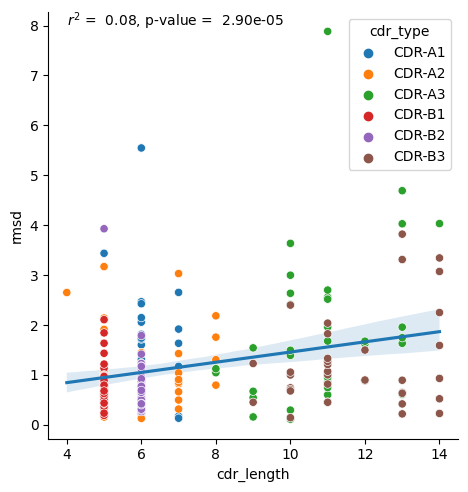

In [15]:
data = results.query("alignment == 'framework'")

r, p_val = scipy.stats.pearsonr(data['cdr_length'], data['rmsd'])

sns.lmplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', scatter=False)
sns.scatterplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', hue='cdr_type')

plt.text(4, 8, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.savefig('../report/figures/cdr_rmsd_vs_length_fw.svg')
plt.show()

## Alignment on loops

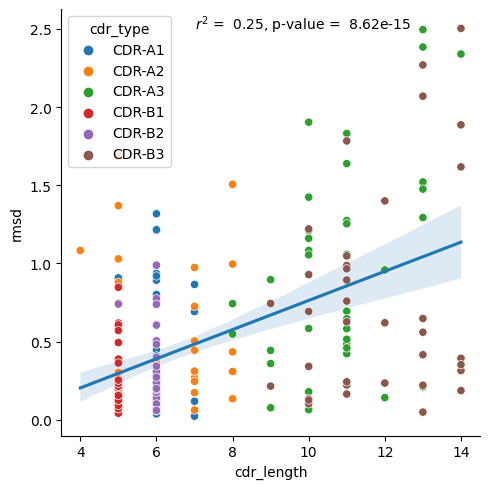

In [16]:
data = results.query("alignment == 'loop'")

r, p_val = scipy.stats.pearsonr(data['cdr_length'], data['rmsd'])

sns.lmplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', scatter=False)
sns.scatterplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', hue='cdr_type')

plt.text(7, 2.5, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.savefig('../report/figures/cdr_rmsd_vs_length_loop.svg')
plt.show()

# Conclusion

There is a correlation in both paradigms, framework alignment and loop alignment, but the correlation is much stronger looking at the loop alignments.
The increased correlation for loop alignments make sense since the conformational changes from the framework regions can be driven by other parts of the protein, but when the loops are aligned together, the only differences can be driven by changes in the loops themselves, implying the loop length has more of an effect.